In [1]:
import numpy as np
import os
import mne
import pickle
import pandas as pd
from mat73 import loadmat
import matplotlib.pyplot as plt
import osl
import yaml

In [12]:
#dataset_path = "/well/woolrich/projects/disp_csaky/OPM/13703_reading/20230510_134805_meg.fif"
dataset_path = "/well/woolrich/projects/disp_csaky/OPM/opm_rich/reading_only/20230314_144007_meg.fif"
raw = mne.io.read_raw_fif(dataset_path, preload=True)

Opening raw data file /well/woolrich/projects/disp_csaky/OPM/opm_rich/reading_only/20230314_144007_meg.fif...
Isotrak not found
    Range : 0 ... 2642399 =      0.000 ...  2201.999 secs
Ready.
Opening raw data file /well/woolrich/projects/disp_csaky/OPM/opm_rich/reading_only/20230314_144007_meg-1.fif...
Isotrak not found
    Range : 2642400 ... 3502559 =   2202.000 ...  2918.799 secs
Ready.
Reading 0 ... 3502559  =      0.000 ...  2918.799 secs...


In [20]:
# select G1, LE, LO, HP channels
channels = [[ch+'[X]', ch+'[Y]', ch+'[Z]'] for ch in ['G1', 'LE', 'LO', 'HP']]
channels = [ch for sublist in channels for ch in sublist]
channels = [ch for ch in channels if ch in raw.ch_names]
channels

['G1[X]',
 'G1[Y]',
 'G1[Z]',
 'LE[X]',
 'LE[Y]',
 'LE[Z]',
 'LO[X]',
 'LO[Y]',
 'LO[Z]',
 'HP[X]',
 'HP[Y]',
 'HP[Z]']

Effective window size : 0.213 (s)


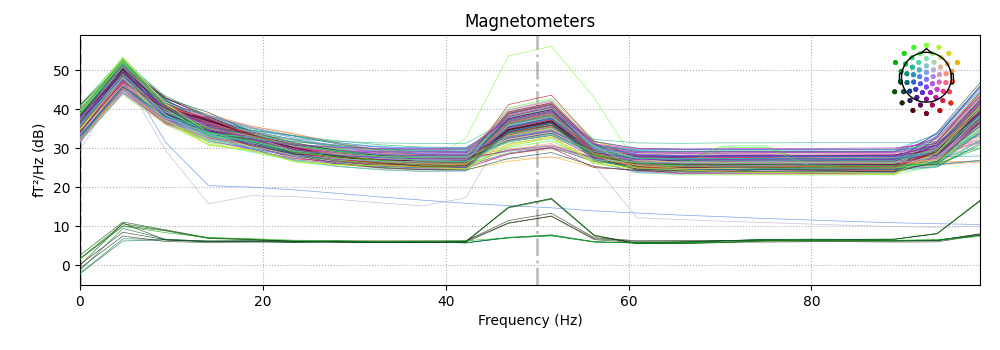

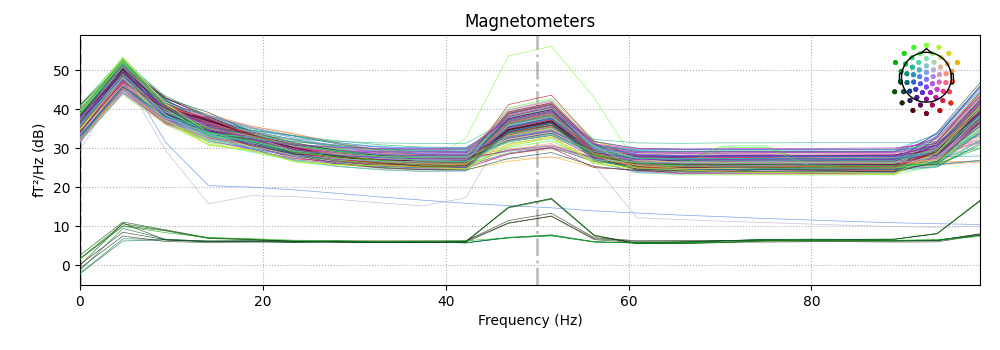

In [38]:
%matplotlib widget
raw.compute_psd(fmax=100).plot()
e=0

In [34]:
raw = raw.pick(picks=['FR[Z]'])

IndexError: index 8 is out of bounds for axis 0 with size 0

In [7]:
# print channel types
print(raw.get_channel_types())

['stim', 'stim', 'stim', 'stim', 'stim', 'stim', 'stim', 'stim', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'ref_meg', 'ref_meg', 'ref_meg', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'ref_meg', 'ref_meg', 'ref_meg', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'ref_meg', 'ref_meg', 'ref_meg', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'ref_meg', 'ref_meg', 'ref_meg', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag', 'mag'

In [8]:
# get channel names of channels that have ref_meg type
ch_types = raw.get_channel_types()
ref_meg_ch_names = [ch for ch in raw.ch_names if 'ref_meg' in ch_types[raw.ch_names.index(ch)]]

In [10]:
# set ref_meg channels to mag
raw.set_channel_types((dict(zip(ref_meg_ch_names, ['mag'] * len(ref_meg_ch_names)))))

<Raw | 20230510_134805_meg.fif, 203 x 3641760 (3034.8 s), ~5.51 GB, data loaded>

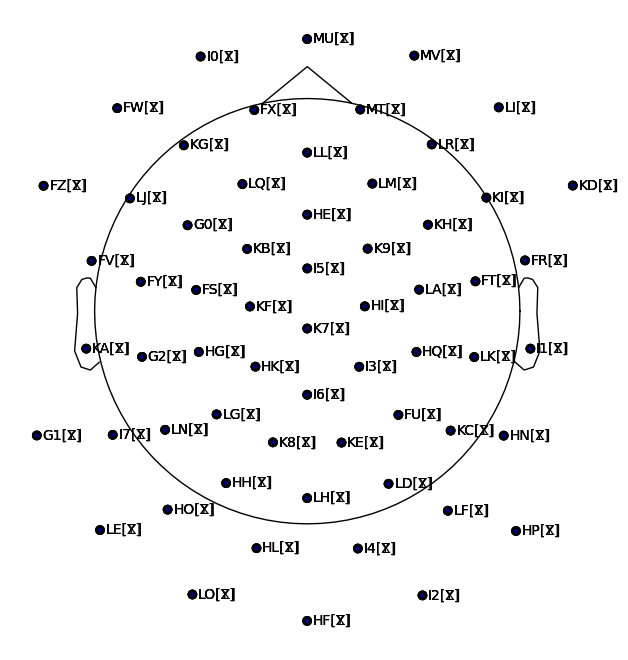

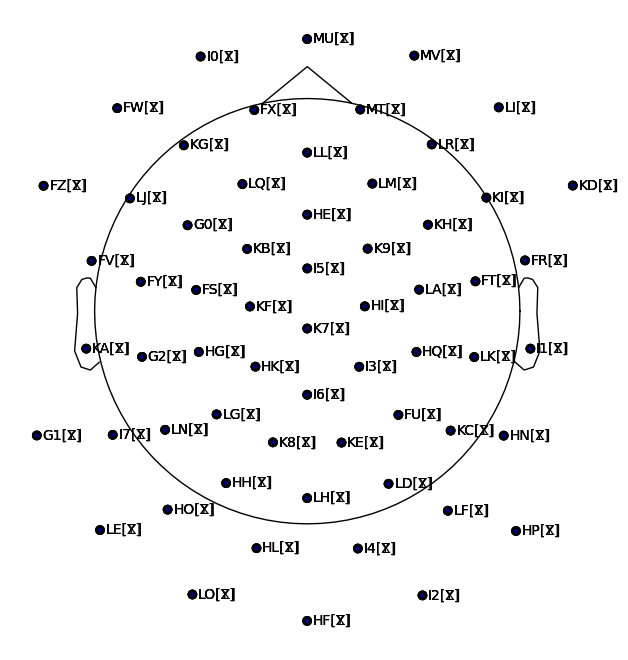

In [13]:
raw.plot_sensors(show_names=True)

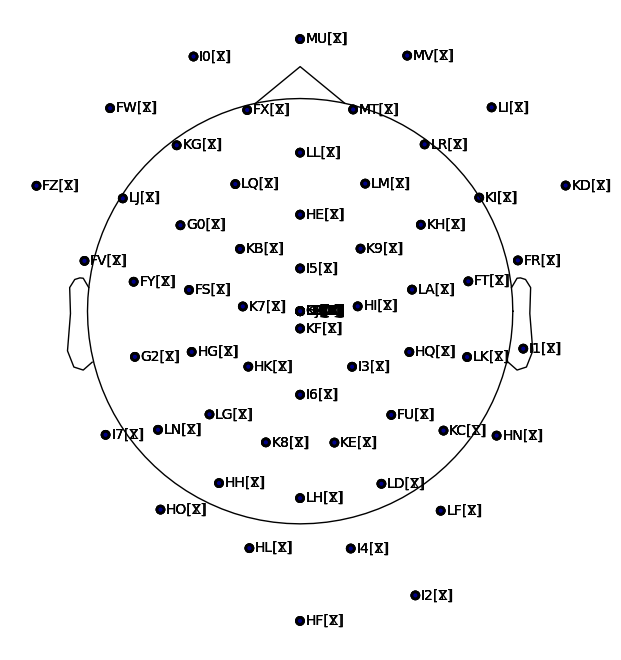

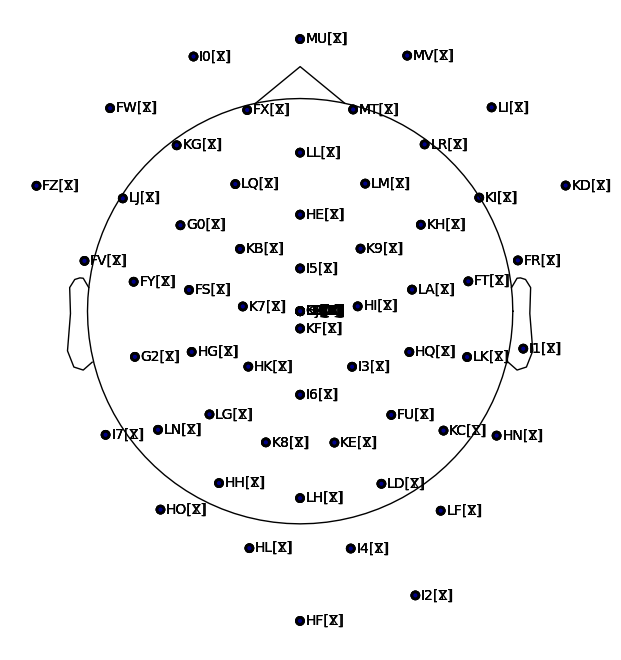

In [11]:
raw.plot_sensors(show_names=True)

In [6]:
# OSL preproc pipeline
outdir = '/well/woolrich/projects/disp_csaky/OPM/13703_reading/osl/'
#- bad_channels:   {picks: 'mag', significance_level: 0.4}
#   - load_bad_channels: {bad_file: '/well/woolrich/projects/disp_csaky/opm_rich/reading_only/highpass_4hz/bad_channels.txt'}

config_text = """
meta:
  event_codes:
    words/hungry: 2
    words/tired: 3
    words/thirsty: 4
    words/toilet: 5
    words/pain: 6
preproc:
  - drop_channels:  {ch_names: ['FW[Y]', 'FZ[Y]', 'HF[Z]', 'I2[Z]']}
  - filter:         {l_freq: 1, h_freq: 25, method: 'iir', iir_params: {order: 5, ftype: butter}}
  - resample:       {sfreq: 100}
  - bad_segments:   {segment_len: 200, picks: 'mag', significance_level: 0.1}
  - bad_segments:   {segment_len: 400, picks: 'mag', significance_level: 0.1}
  - bad_segments:   {segment_len: 600, picks: 'mag', significance_level: 0.1}
  - bad_segments:   {segment_len: 800, picks: 'mag', significance_level: 0.1}
  - ica_raw:        {picks: 'mag', n_components: 64}
"""

In [7]:
# run OSL preprocessing
config = yaml.load(config_text, Loader=yaml.FullLoader)
dataset = osl.preprocessing.run_proc_chain(config,
                                           dataset_path,
                                           outdir=outdir,
                                           overwrite=True,
                                           gen_report=True)

20230510_134805_meg : OSL osl_logger: handler 'console' level set to 'INFO'
20230510_134805_meg : logging to file: /well/woolrich/projects/disp_csaky/OPM/13703_reading/osl/20230510_134805_meg/logs/20230510_134805_meg_preproc_raw.log
20230510_134805_meg : 2023-05-16 16:44:38 : Starting OSL Processing
20230510_134805_meg : input : /well/woolrich/projects/disp_csaky/OPM/13703_reading/20230510_134805_meg.fif
20230510_134805_meg : IMPORTING: /well/woolrich/projects/disp_csaky/OPM/13703_reading/20230510_134805_meg.fif
20230510_134805_meg : Detected fif file format, using: mne.io.read_raw_fif
20230510_134805_meg : MNE Stage - raw.drop_channels
20230510_134805_meg : userargs: {'ch_names': ['FW[Y]', 'FZ[Y]', 'HF[Z]', 'I2[Z]']}
20230510_134805_meg : MNE Stage - raw.filter
20230510_134805_meg : userargs: {'l_freq': 1, 'h_freq': 25, 'method': 'iir', 'iir_params': {'order': 5, 'ftype': 'butter'}}
20230510_134805_meg : MNE Stage - raw.resample
20230510_134805_meg : userargs: {'sfreq': 100}
20230510_

In [12]:
raw_proc = dataset['raw']
raw_proc = raw_proc.pick('mag')

In [13]:
print(raw_proc.info['bads'])
len(raw_proc.ch_names)

[]


164

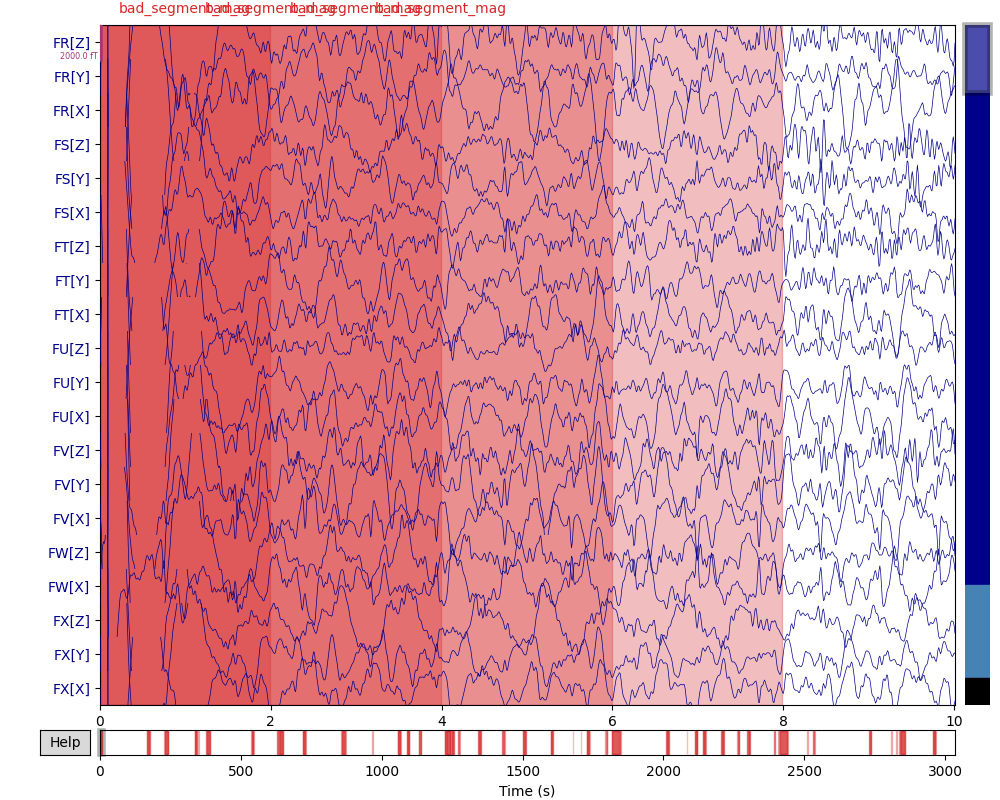

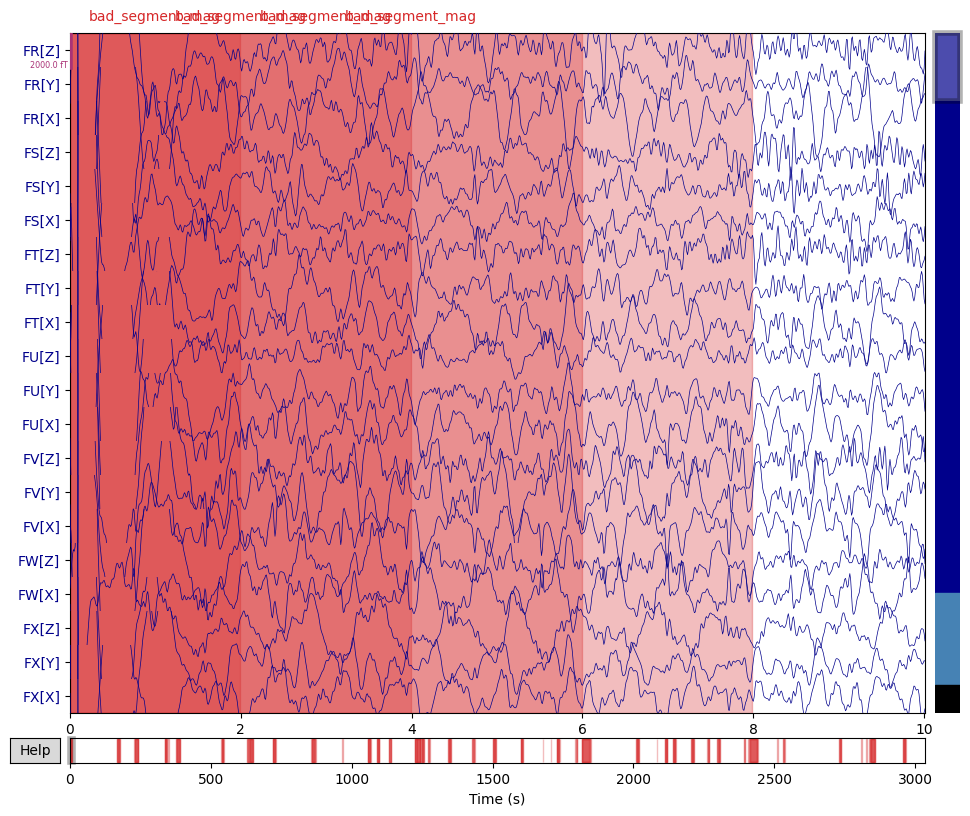

In [8]:
# plot the data
%matplotlib widget
dataset['raw'].plot()

In [15]:
# select x, y, z channels
x_inds = [i for i, c in enumerate(raw_proc.ch_names) if '[X]' in c]
y_inds = [i for i, c in enumerate(raw_proc.ch_names) if '[Y]' in c]
z_inds = [i for i, c in enumerate(raw_proc.ch_names) if '[Z]' in c]

In [16]:
ica = dataset['ica']

In [17]:
# Get components and sources
comps = ica.get_components()
ica_sources = ica.get_sources(raw_proc).get_data()

In [18]:
ch_names = [c for c in raw_proc.ch_names if '[Z]' in c]
info_z = raw_proc.copy().pick_channels(ch_names).info

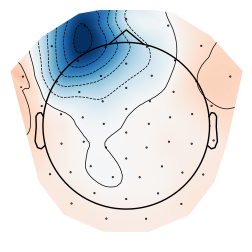

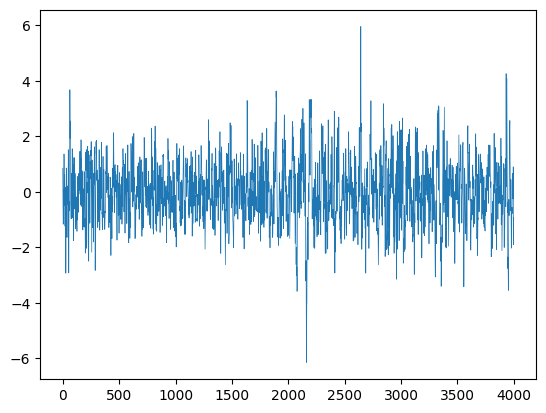

In [53]:
# plot component timeseries and topographies
%matplotlib inline
index = 32

# set figsize
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
mne.viz.plot_topomap(comps[z_inds, index], info_z, axes=ax)

plt.plot(ica_sources[index][180000:184000], linewidth=0.5)

In [54]:
# set components to exclude
ica.exclude = [6, 11, 12, 21]

In [55]:
# apply ica to the data
raw_proc = ica.apply(raw_proc)

In [56]:
# save data
raw_proc.save(outdir + 'raw_preproc.fif')

/tmp/ipykernel_13958/281241309.py:2: RuntimeWarning: This filename (/well/woolrich/projects/disp_csaky/OPM/13703_reading/osl/raw_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_proc.save(outdir + 'raw_preproc.fif')
